# $GROUP$ $36$ $PROJECT$ $REPORT$
### $Predicting$ $Water$ $Levels$ $in$ $Venice$

**INTRODUCTION**

For our project, we are going to observe a dataset that describes water levels in Venice, Italy. Venice is known for its yearly flooding and is at risk of completely flooding in the future if water levels continue to rise. This dataset contains data from 1983 to 2015, and includes the water level in centimeters for every hour of every day. Our predictive question is:
### “What will the average water level in Venice be in the years following 2015?” 

Flooding in Venice is much more impactful and frequent than in other cities, as it is built on multiple small islands connected by bridges and water canals. Its location causes it to flood on a regular basis, but due to global warming and the nature of Venice’s geography, the floods have become increasingly severe over the years. For example, on November 12th 2019, residents of Venice went through the usual routine to prepare for a flood. The water level started to rise far above the predicted water level, destroying homes, business, and historical landmarks, and costing the city millions of dollars. A significant portion of Venice's economy relies on tourism and trade through its ports. Any significant flood would drive tourists away and slow down port activity, impacting the economy of the city on top of flood damage repairs. The floods in Venice are becoming more destructive and unpredictable, costing the city more and more each year, which is why we need to predict the water levels far into the future, so that the city can prepare for even higher floods. 

We aim to observe possible trends in the average water levels per year, starting from 1983, and use linear regression to predict how much the water level will increase in the future. Since the dataset ends at the year 2015, we want to predict the water level every 5 years following 2015 until 2050.


**DATA ANALYSIS**


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We first loaded in our dataset and cleaned it by separating the `datetime` column into separate columns for year, month, and date. We used all the data from the original dataset, and did not need to remove any variables, as the dataset contains all the information we need already; the different water levels and the time at which they were recorded.

Next, we wrangled our data so that it contained the values we needed for our prediction. We filtered out the year 2016, as there was only 1 data point for it whereas the other years had thousands of data points. This prevents the data for 2016 from being an outlier. We then grouped our data by year and month and summarized it to take the mean of the water levels. This gives us an overall average water level for every month of every year from 1983 to 2015. 

In [2]:
set.seed(2000) 

#read in dataset from web
data<-read_csv('https://github.com/lbcommer/venezia-high-waters/raw/master/output/venezia.csv') |>
                                separate(col=datetime, into=c('Year', 'Month', 'Date'), sep='-', convert=TRUE) |>
                                separate(col=Date, into=c('Day', 'Time'), sep=" ", convert=TRUE)

#filter the data and summarize it so it shows the monthly average of water levels in cm from 1983 to 2015
filtered_data <- data |>  
filter(Year != "2016") |> group_by(Year,Month) |> summarise(month_average = mean(level)) 
print("Table 1: Filtered data with monthly average of water levels(cm)")

filtered_data

# used time series function because our data shows water levels over a progression of time
water_ts <- ts(filtered_data, start = c(1983, 1), end = c(2015, 12), frequency = 12)

water_data <- as.data.frame(water_ts)

Rows: 289272 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): level
dttm (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


[1] "Table 1: Filtered data with monthly average of water levels(cm)"


Year,Month,month_average
<int>,<int>,<dbl>
1983,1,7.30148
1983,2,19.67262
1983,3,16.70430
⋮,⋮,⋮
2015,10,41.88038
2015,11,32.03889
2015,12,15.00941


Then, we converted the `Month` column into a sequence of numbers starting from 1 and ending at 396, therefore assigning a unique number to every month of every year. We did this because we are observing water levels over the progression of time. By doing this, we also no longer need the `Year` column, so we removed it.

For spliting the data we chose a 70/30 split. We want to predict the monthly average water level for every month of future years, therefore we split the data after wrangling so the testing and training data were both the same format.


In [3]:
set.seed(2000)

# add a sequence as a counter for the month starting from January 1983 and delete the year column
water_df <- mutate(water_data, tibble(Month = seq(1,396))) |>
    select(- Year)

# we split our data into training and testing datasets, in a 70/30 proportion
data_split <- initial_split(water_df, prop = 0.7, strata = Month)
training_data <- training(data_split)
testing_data <- testing(data_split)

print("Table 2: Monthly average of water levels in cm with month")
water_df
print("Table 3: Training Data")
training_data
print("Table 4: Testing Data")
testing_data

[1] "Table 2: Monthly average of water levels in cm with month"


Month,month_average
<int>,<dbl>
1,7.30148
2,19.67262
3,16.70430
⋮,⋮
394,41.88038
395,32.03889
396,15.00941


[1] "Table 3: Training Data"


,Month,month_average
,<int>,<dbl>
1,1,7.30148
2,2,19.67262
3,3,16.70430
⋮,⋮,⋮
392,392,34.35618
394,394,41.88038
396,396,15.00941


[1] "Table 4: Testing Data"


,Month,month_average
,<int>,<dbl>
4,4,26.35972
8,8,19.64382
9,9,21.39583
⋮,⋮,⋮
390,390,28.97083
393,393,38.80556
395,395,32.03889


From broad inspection of the tibbles above, we can see that the values in the `month_average` column, which represents the average water level for each month of each year, fluctuate between different months. This shows that water levels do not follow a strict linear increase from January to December each year; this makes sense, because water levels are largely dependent on the weather and season of specific times. Despite these fluctuations, however, we can observe that on a broad level, the water levels are increasing, as the values at the tail of each tibble are higher than the values at the head of each tibble. 

Below is an initial plot of our training data. It shows the average water levels for every month of every year in our dataset, from January 1983 to December 2015. From the plot, we can observe that the average water levels fluctuate quite frequently between different months and years. However, there is an overall increasing trend as the years go by, indicating that on a broad level, water levels in Venice are rising as time passes.

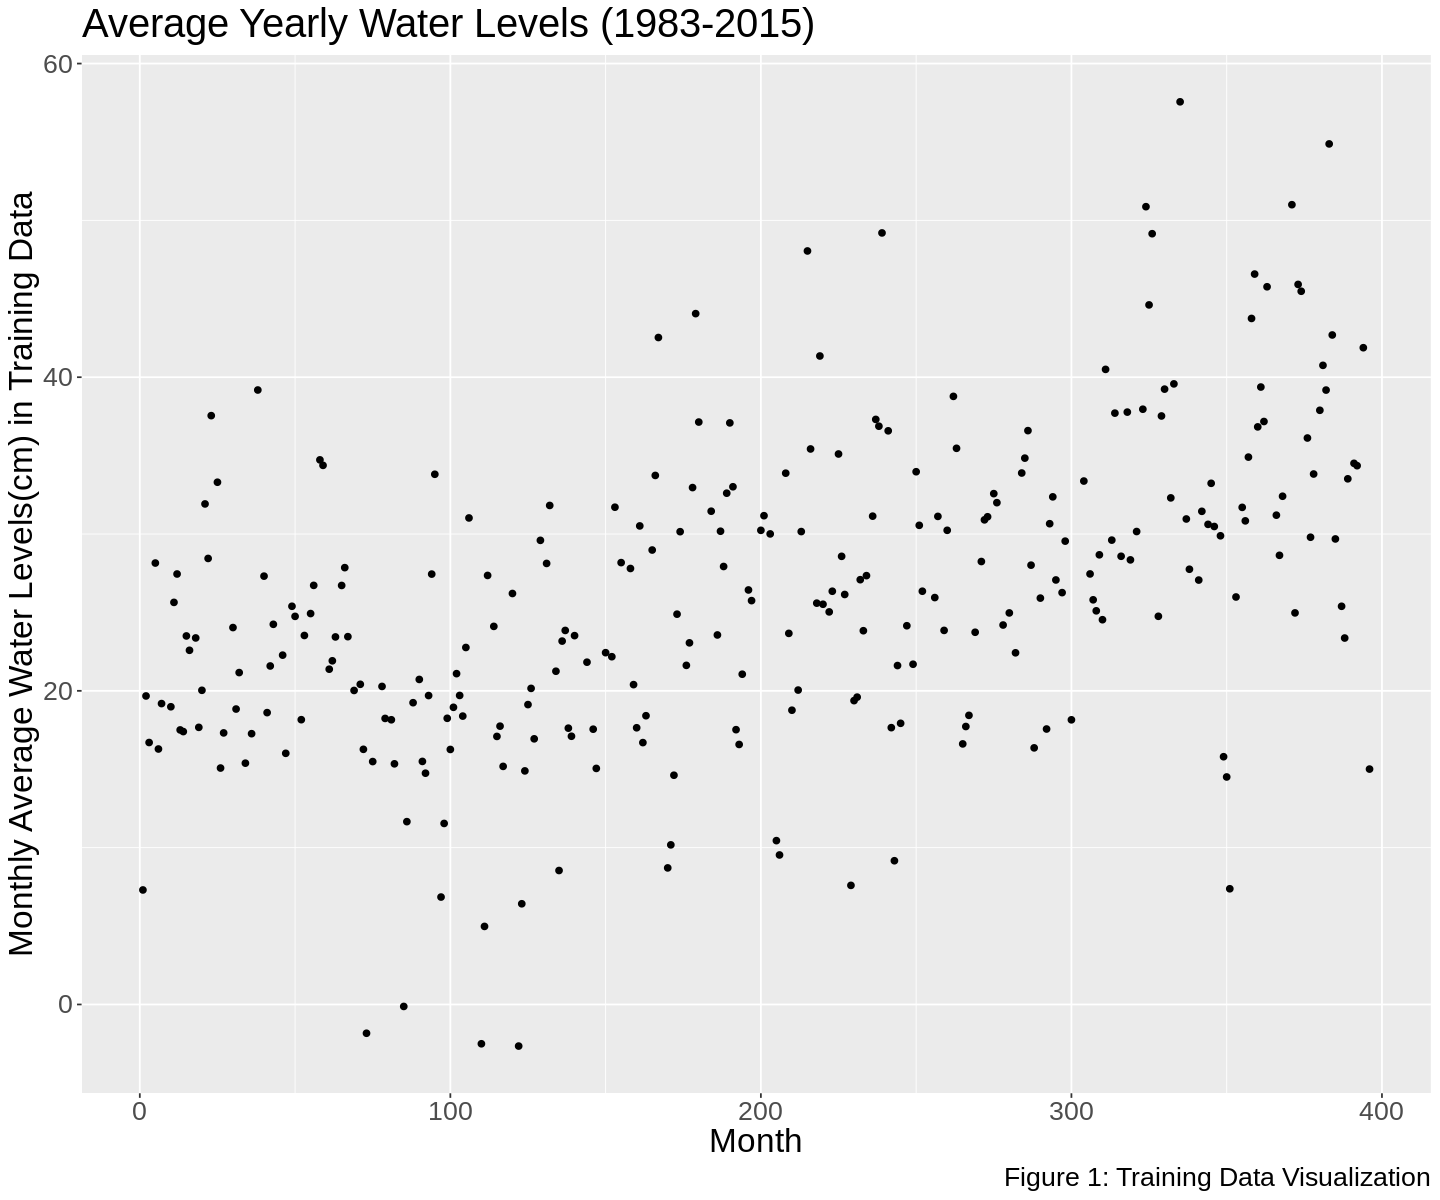

In [4]:
# visualize the training data of the monthly average water levels
options(repr.plot.width = 12, repr.plot.height = 10)

graph_data <- training_data |>
    ggplot(aes(x = Month, y = month_average)) +
    geom_point() +
    labs(x = "Month", 
         y = "Monthly Average Water Levels(cm) in Training Data", 
         title = "Average Yearly Water Levels (1983-2015)",
         caption = "Figure 1: Training Data Visualization") +
    theme(text = element_text(size = 20)) 

graph_data

Next, we created, trained, and fit our regression model. We chose to use linear regression to answer our predictive question because we are trying to predict a numerical value. For our recipe, we used `Month` as our predictor variable. `month_average` is our response variable, as we are trying to predict the water level.

In [5]:
set.seed(2020)

# making the model for the prediction line
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# making a recipe for our model; predictor variable is Month, response variable is month_average
data_recipe <- recipe(month_average ~ Month, data = training_data)

# fit our model into workflow
data_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(lm_spec) |>
  fit(data = training_data)

data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)        Month  
   17.67798      0.04213  


By inspection of the coefficients of our trained model above, we can see that there is a positive intercept and a positive value for `Month`. This indicates that the slope of our linear regression line is positive, which proves that as time passes, water levels are increasing.

We then evaluated the accuracy of our model by calculating the RMSE resulting from predicting on our training data, and then the RMSPE resulting from predicting on our testing data.

In [6]:
# calculating the root mean squared error (RMSE) of the model in training data
lm_rmse <- data_fit |>
  predict(training_data) |>
  bind_cols(training_data) |>
  metrics(truth = month_average, estimate = .pred) |>
  filter(.metric == "rmse") |>
  select(.estimate) |>
  pull()

lm_rmse

[1] 8.580688

In [7]:
# calculating the root mean squared predicted error (RMSPE) of the model in testing data
lm_rmspe <- data_fit |>
  predict(testing_data) |>
  bind_cols(testing_data) |>
  metrics(truth = month_average, estimate = .pred) |>
  filter(.metric == "rmse") |>
  select(.estimate) |>
  pull()

lm_rmspe

[1] 8.584946

Below is a visualization of our linear regression line plotted onto our data points. It is observed that the line has a positive slope, indicating the increase of water levels as time passes. As well, we have shown our model workflow again. Using the coefficients from the model, we can create an equation for the regression line that will allow us to predict the water level for future years.


`geom_smooth()` using formula 'y ~ x'



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)        Month  
   17.67798      0.04213  


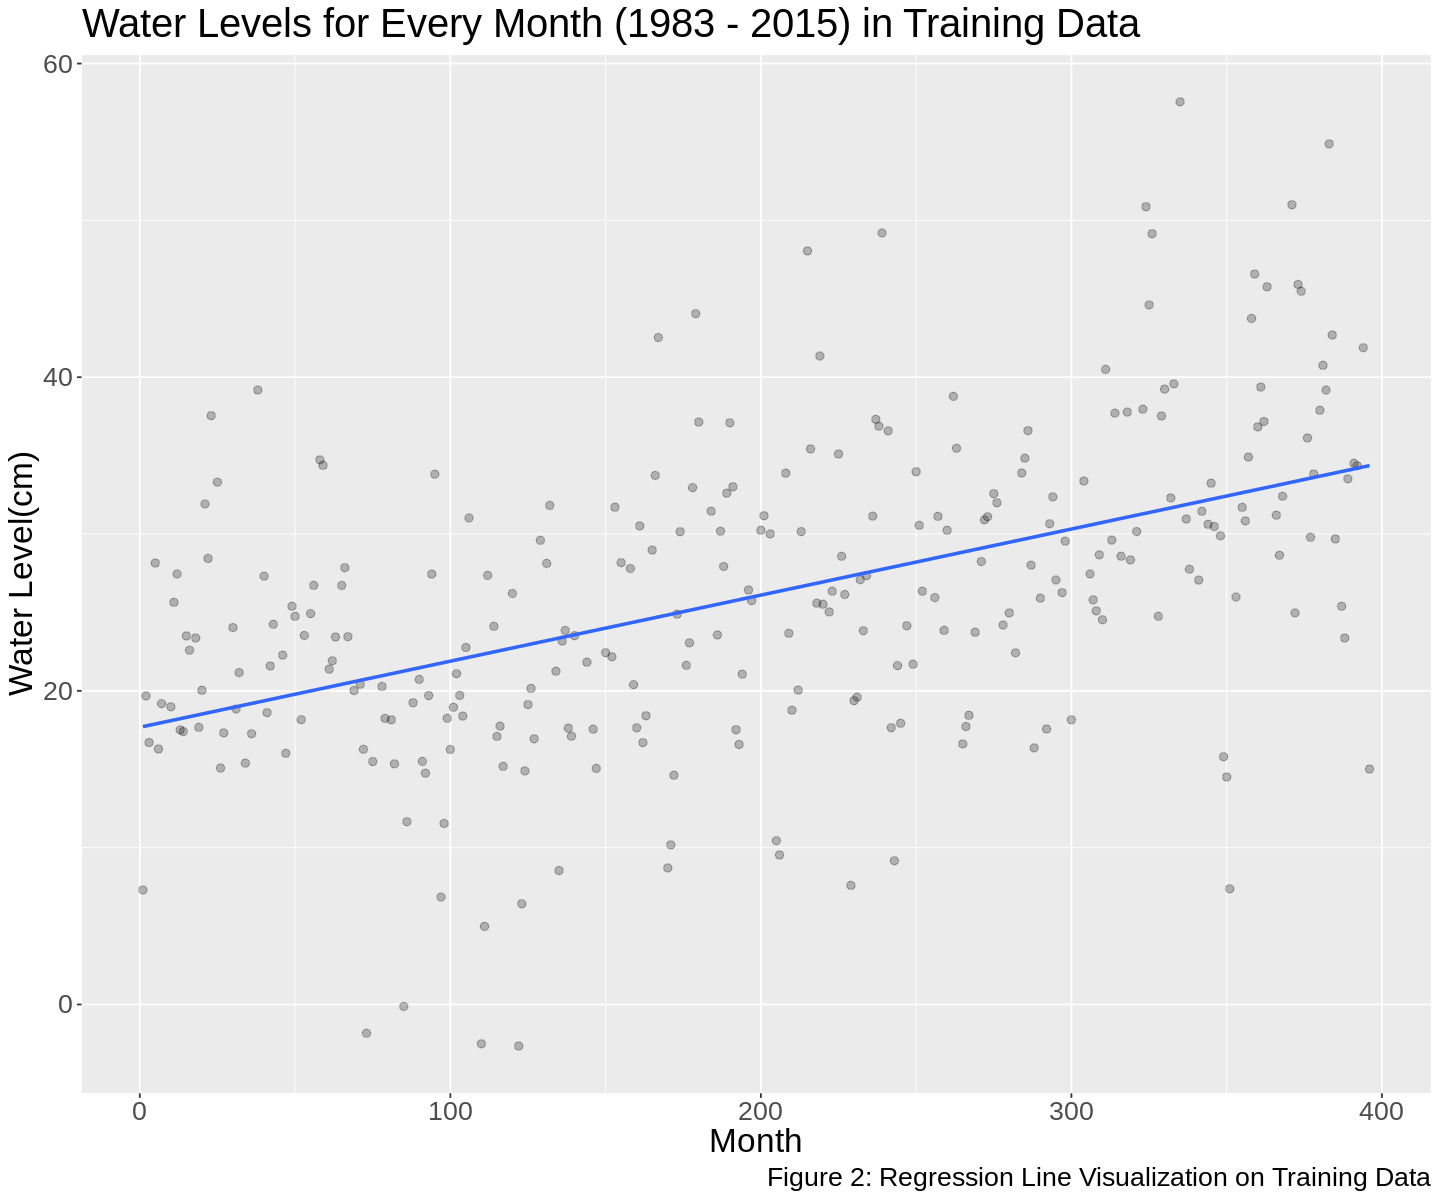

In [8]:
# plot the model in training data and show the model to get the intercept and slope of the prediction line
options(repr.plot.width = 12, repr.plot.height = 10)

lm_predictions_test <- training_data |>
     ggplot(aes(x = Month, y = month_average)) +
         geom_point(alpha = 0.25, size=2) +
         geom_smooth(data = training_data, aes(x = Month, y = month_average), method = "lm", se = FALSE) +
         xlab("Month") +
         ylab("Water Level(cm)") +
         ggtitle("Water Levels for Every Month (1983 - 2015) in Training Data") +
         labs(caption = "Figure 2: Regression Line Visualization on Training Data") +
         theme(text = element_text(size = 20))

lm_predictions_test

data_fit

Based on the coefficients of our trained model, we can extract an equation for our regression line.

**EQUATION OF REGRESSION LINE:**

$water\: level = 17.67798 + 0.04213*Month$

We can find the expected average water level for any month of any year by plugging the month's corresponding number into the equation. With January 1983 being month 1.

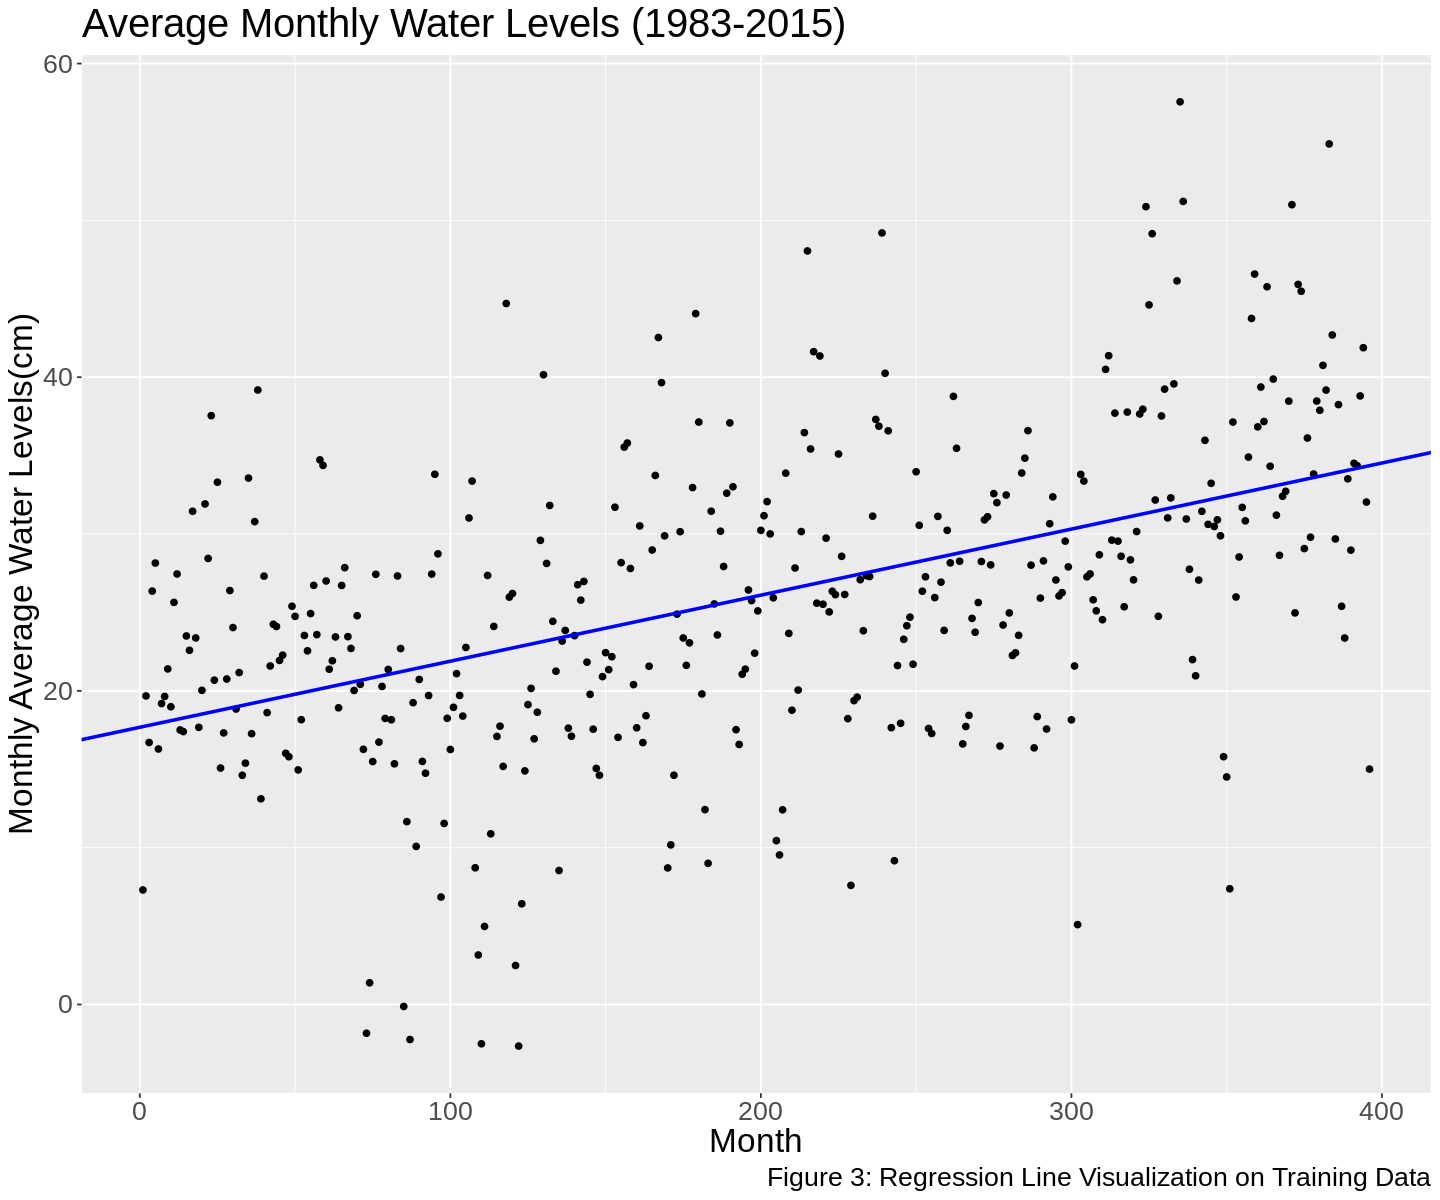

In [9]:
# plot the line using the intercept and slope we have on the original data
options(repr.plot.width = 12, repr.plot.height = 10)

prediction_line <- ggplot(water_df, aes(x = Month, y = month_average)) + 
    geom_point() +
    labs(x = "Month", y = "Monthly Average Water Levels(cm)", title = "Average Monthly Water Levels (1983-2015)",
        caption = "Figure 3: Regression Line Visualization on Training Data") +
    geom_abline(intercept=17.67798, slope=0.04213, color='blue', lwd=1) +
    theme(text = element_text(size = 20))

prediction_line

In the cell below, we used the equation of the regression line extracted above and plugged in different `Month` numbers to obtain the average water level for that month. We used January of each year to keep it consistant.

In [10]:
#in this cell we calculate all the predicted values for multiple years following 2015 using the slope formula obtained

#month 433 corresponds to january 2020
pred_1 <- 17.67798 + 433*0.04213
pred_1

#month 493 corresponds to january 2025
pred_2 <- 17.67798 + 493*0.04213
pred_2

#month 553 corresponds to january 2030
pred_3 <- 17.67798 + 553*0.04213
pred_3

#month 613 corresponds to january 2035
pred_4 <- 17.67798 + 613*0.04213
pred_4

#month 673 corresponds to january 2040
pred_5 <- 17.67798 + 673*0.04213
pred_5

#month 733 corresponds to january 2045
pred_6 <- 17.67798 + 733*0.04213
pred_6

#month 793 corresponds to january 2050
pred_7 <- 17.67798 + 793*0.04213
pred_7

[1] 35.92027

[1] 38.44807

[1] 40.97587

[1] 43.50367

[1] 46.03147

[1] 48.55927

[1] 51.08707

We converted this predicted water level data into a table to better understand and interpret it. The year corresponds to January of each year.

In [11]:
options(repr.matrix.max.rows = 8)

print("Table 5: Predicted water levels in cm every 5 years")
predicted_water_levels_until_2050 <- tibble(Year=c(2020, 2025, 2030, 2035, 2040, 2045, 2050),
                        'Predicted Water Level (cm)'=c(35.92027, 38.44807, 40.97587, 43.50367, 46.03147, 48.55927, 51.08707))
predicted_water_levels_until_2050         

[1] "Table 5: Predicted water levels in cm every 5 years"


Year,Predicted Water Level (cm)
<dbl>,<dbl>
2020,35.92027
2025,38.44807
2030,40.97587
2035,43.50367
2040,46.03147
2045,48.55927
2050,51.08707


**SUMMARY OF RESULTS**

Throughout this project, our group has been dedicated to solving our research question. In order to do so, we have had to wrangle our data, sort it into training and testing data and then conduct linear regression on our model. Demonstrated through the evidence above, our line of regression has a positive slope of 0.04213, suggesting that there is a positive correlation between time and water level. Through this discovery within our data, our group was able to extend the line of regression in order to obtain an estimate of the water level for every 5 years following 2015. For example, 2020, 2025, until 2050.

The following observations have aligned with our expected outcome, as we hypothesized that water levels would have a positive trend upwards. We arrived at this hypothesis because water levels have been rising all around the world due to the ongoing impact of global warming. The following hypothesis was further reassured through our preliminary analysis which can be seen within our initial plot, vaguely indicating there is a general upwards trend over time therefore suggesting water levels in Venice are rising as time passes. 

Our group believes investigating this topic is extremely important, especially since the effects of global warming are more present than ever in our daily lives. More specifically, a city like Venice is frequently under the risk of flooding, therefore the municipality must be aware of the rising water levels in order to ensure the safety of their infrastructure and community. Primarily they have started using the water prevention system MOSE (Modulo Sperimentale Elettromeccanico) which is a series of mobile steel gates that are raised and lowered on command. Through our findings we believe the government can use our data in order to aid them in preparing and adapting the MOSE to withhold the rising sea levels anticipated.


After obtaining such significant results within this project, we hope to encourage future researchers to further investigate this topic. We believe the following questions would be relevant to investigate the topic further.

- How will Venice’s municipality adequately adapt the MOSE to withstand the future water levels?

- Will Venice sink if this upwards trend in water levels continues?

- How exactly is global warming contributing to this and what ways can we prevent this? 


**CITATIONS**

Kaggle citation:
Luis Bronchal,  “Water Levels in Venezia, Italia” *Kaggle*, 08 Febuary 2017 
    
https://www.kaggle.com/datasets/lbronchal/venezia



Shirin Ali, “an expert explains how rising sea levels could result in Venice falling into the sea” *Changing America*,  01 November 2021
   
https://thehill.com/changing-america/sustainability/climate-change/579490-an-expert-explains-how-rising-sea-levels-could/



Rebecca Ann Hughes, “Venice 1 Year On From Devastating Flooding: No More Acqua Alta?" *Forbes*, 12 November 2020
   
https://www.forbes.com/sites/rebeccahughes/2020/11/12/venice-1-year-on-from-devastating-flooding-no-more-acqua-alta/?sh=72bd5a944809



Ellen Cranley, “9 photos show flooding in Venice that has caused more than $1 billion in damages to the city's homes and historical sites” *Insider*, 
    23 December 2019 
    
https://www.businessinsider.com/flooding-cost-1-billion-of-damage-to-venice-tourist-attractions-2019-12



Nathan Chandler, “How the Venice Tide Barrier Project Works” *How Stuff Works* , 26 April 2014 
    
https://science.howstuffworks.com/engineering/civil/how-the-venice-tide-barrier-project-works.htm




